In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from pandas import DataFrame

## Merge all Raw CSV files for different benchmark runs

In [48]:
# List all benchmark versions to merge together
benchmark_versions_old: list = ['v0.9', 'v1.0']
benchmark_versions_new: list = ['v1.5', 'v1.5_quantized','v1.6','v1.6_backends','v1.6_quantized',]
merged_df = []

for i, benchmark_versions in enumerate(benchmark_versions_new):
    raw_df: DataFrame = pd.read_csv(f'./{benchmark_versions}/raw.csv')

    # change the episode name by appending the benchmark version. This helps to avoid duplicate error in pivot function
    raw_df.episode = raw_df.episode.map(lambda x: f'{x}_{benchmark_versions}')

    # merge the new benchmark version to all previous ones
    merged_df = raw_df if i == 0 else pd.concat([merged_df, raw_df], axis=0)

In [49]:
def get_pivot_from_df(df: DataFrame):
    metriclist = ['Success', 'Aborted', 'Lose']
    df_aux = df[df.metric.isin(metriclist)]
    
    # Pivot the DataFrame
    df_pivot = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                             columns='metric',
                             values='value')
                .reset_index()
                .drop(columns=['experiment', 'episode'])
                .groupby(['model', 'game'])
                .sum()
                .drop(columns=['Lose', 'Aborted']))
    return df_pivot
    

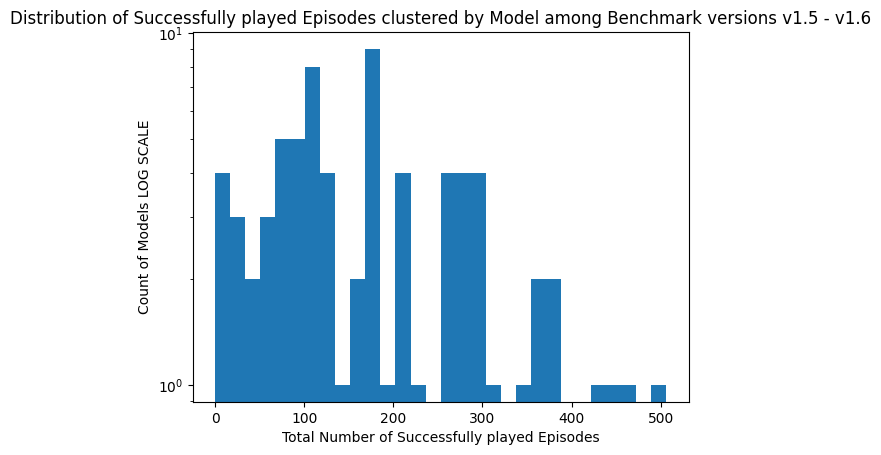

In [50]:
def plot_histogram_of_all_playable_episodes(df, title,  save=False, save_path: str = ''):
    metriclist = ['Success', 'Aborted', 'Lose']
    df_aux = df[df.metric.isin(metriclist)]

    # Pivot the DataFrame
    df_pivot = get_pivot_from_df(df=df_aux)

    # Reset the index to have 'game' as columns and 'model' as rows
    df_stacked = df_pivot.reset_index().pivot(index='model', columns='game', values='Success').fillna(0)

    # compute the total successes among all games
    df_stacked['total_success'] = df_stacked.sum(axis=1)

    df_stacked.total_success.plot(kind='hist', bins=30, log=True)

    plt.xlabel('Total Number of Successfully played Episodes')
    plt.ylabel('Count of Models LOG SCALE')
    plt.title(title)
    
    if save:
        plt.savefig(save_path, bbox_inches='tight')
    
# plot
title: str = "Distribution of Successfully played Episodes clustered by Model among Benchmark versions v1.5 - v1.6"
plot_histogram_of_all_playable_episodes(merged_df, save=True, title=title, save_path='./Plots/Distribution_of_Successfully_Played_Episodes_v1_5-1_6.png')

## Filter the top k Models according to the most episodes successfully played

In [51]:
def get_top_k_models(df, k=10):
    metriclist = ['Success', 'Aborted', 'Lose']
    df_aux = df[df.metric.isin(metriclist)]

    # Pivot the DataFrame
    df_pivot = get_pivot_from_df(df=df_aux)

    # Reset the index to have 'game' as columns and 'model' as rows
    df_stacked = df_pivot.reset_index().pivot(index='model', columns='game', values='Success').fillna(0)

    # compute the total successes among all games
    df_stacked['total_success'] = df_stacked.sum(axis=1)
    df_stacked = df_stacked.sort_values(by='total_success', ascending=False)
    return df_stacked.head(k)

In [52]:
# get the top k models with the most total successful episodes among all games
models_to_include: list = list(get_top_k_models(merged_df, 10).index)

# filter merged df to only include top k models
merged_df_top_k = merged_df[merged_df.model.isin(models_to_include)]

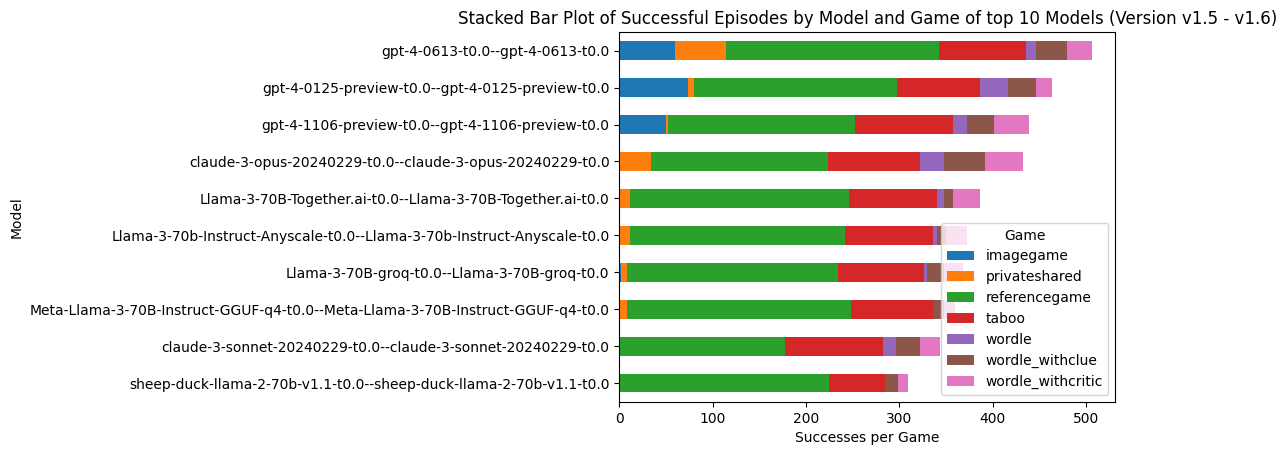

In [53]:
def custom_stacked_barplot(df, title, save=False, save_path=''):
    metriclist = ['Success', 'Aborted', 'Lose']
    df_aux = df[df.metric.isin(metriclist)]

    # Pivot the DataFrame
    df_pivot = get_pivot_from_df(df=df_aux)

    # Reset the index to have 'game' as columns and 'model' as rows
    df_stacked = df_pivot.reset_index().pivot(index='model', columns='game', values='Success').fillna(0)
    df_stacked['total_success'] = df_stacked.sum(axis=1)
    df_stacked = df_stacked.sort_values(by='total_success', ascending=True)
    df_stacked = df_stacked.drop(columns=['total_success'])

    # Plotting the stacked bar plot
    df_stacked.plot(kind='barh', stacked=True)

    # Adding labels and title
    plt.xlabel('Successes per Game')
    plt.ylabel('Model')
    plt.title(title)
    plt.legend(title='Game')
    
    if save:
        plt.savefig(save_path, bbox_inches='tight')
    # Display the plot
    plt.show()

title: str = 'Stacked Bar Plot of Successful Episodes by Model and Game of top 10 Models (Version v1.5 - v1.6)'
custom_stacked_barplot(merged_df_top_k, title=title, save=True, save_path='./Plots/Barchart_Top_k_Models_v1_5-1_6.png')